In [32]:
import pandas as pd
from os.path import join
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
from sklearn import svm
from sklearn.model_selection import PredefinedSplit, GridSearchCV
import warnings

In [33]:
#Reads in training dataset (80% of given observations)
data_path = join("..", "data")
df = pd.read_csv(join(data_path, "train_X.csv"))
numeric_columns = ['min', 'max', 'mean', 'sd', 'range',
       'sum','duplicates', 'mra_D1_min', 'mra_D1_max', 'mra_D1_mean', 'mra_D1_sd',
       'mra_D1_range', 'mra_D1_zero', 'mra_D2_min', 'mra_D2_max',
       'mra_D2_mean', 'mra_D2_sd', 'mra_D2_range', 'mra_D2_zero', 'mra_D3_min',
       'mra_D3_max', 'mra_D3_mean', 'mra_D3_sd', 'mra_D3_range', 'mra_D3_zero',
       'tri_min', 'tri_max', 'tri_mean', 'tri_sd', 'tri_range', 'var_sill',
       'var_range', 'var_kappa', 'Trimmed_mean', 'Median', 'Skew', 'SD',
       'Left_mean', 'Left_SD', 'Left_median', 'Left_skew',
       'Right_mean', 'Right_SD', 'Right_median', 'Right_skew']
# df = pd.concat([df[['image_id', 'classification']], pd.DataFrame(StandardScaler().fit_transform(df[numeric_columns]), columns=numeric_columns)])
df = pd.concat([
    df[['image_id', 'classification']],
    pd.DataFrame(StandardScaler().fit_transform(df[numeric_columns]), columns=numeric_columns)
], axis=1)

#Reads in validation dataset (15% of given observations)
df_val = pd.read_csv(join(data_path, 'validate_X.csv'))
df_val = pd.concat([
    df_val[['image_id', 'classification']],
    pd.DataFrame(StandardScaler().fit_transform(df_val[numeric_columns]), columns=numeric_columns)
], axis=1)

#Reads in test dataset (5% of given observations)
df_test = pd.read_csv(join(data_path, 'test_X.csv'))
df_test = pd.concat([
    df_test[['image_id', 'classification']],
    pd.DataFrame(StandardScaler().fit_transform(df_test[numeric_columns]), columns=numeric_columns)
], axis=1)

In [34]:
X_train = df.drop(['image_id','classification','min','max','range','sd','mean'],axis=1)
y_train = df['classification']
X_val = df_val.drop(['image_id','classification','min','max','range','sd','mean'],axis=1)
y_val = df_val['classification']
X_test = df_test.drop(['image_id','classification','min','max','range','sd','mean'],axis=1)
y_test = df_test['classification']


#clf = LogisticRegression(random_state=0,max_iter=1000).fit(X_train, y_train)
clf = RandomForestClassifier().fit(X_train, y_train)
# clf = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)
#clf = svm.SVC(C = 1).fit(X_train, y_train)

print(f"Train Accuracy: {round(clf.score(X_train, y_train), 3)}")
print(f"Test Accuracy: {round(clf.score(X_val, y_val), 3)}")

print(confusion_matrix(y_val, clf.predict(X_val)))

print("\nFeature importances:")
zipped_lists = zip(clf.feature_importances_, X_train.columns)
sorted_pairs = sorted(zipped_lists, reverse=True)
for pair in sorted_pairs:
    print(f"{round(pair[0], 2)} {pair[1]}")

Train Accuracy: 1.0
Test Accuracy: 0.348
[[ 0  8 63]
 [ 0 18  2]
 [ 0 15 29]]

Feature importances:
0.13 var_range
0.09 Left_median
0.08 sum
0.07 Trimmed_mean
0.06 Median
0.06 Left_mean
0.05 Right_skew
0.05 Skew
0.03 Right_mean
0.03 Right_median
0.02 Left_SD
0.02 SD
0.02 var_kappa
0.02 mra_D1_max
0.02 Left_skew
0.02 mra_D1_range
0.02 mra_D2_max
0.01 mra_D1_sd
0.01 mra_D3_min
0.01 Right_SD
0.01 mra_D1_min
0.01 tri_min
0.01 mra_D2_range
0.01 mra_D3_range
0.01 tri_max
0.01 tri_sd
0.01 tri_mean
0.01 mra_D3_sd
0.01 mra_D2_sd
0.01 tri_range
0.01 mra_D3_zero
0.01 mra_D3_max
0.01 mra_D1_zero
0.01 mra_D2_min
0.01 mra_D2_zero
0.01 var_sill
0.01 mra_D1_mean
0.0 mra_D2_mean
0.0 mra_D3_mean
0.0 duplicates


In [35]:
#Creates an index list to be used so that gridsearchcv differentiates between existing training and validation sets
split_index = [-1]*len(X_train) + [0]*len(X_val)
ps = PredefinedSplit(test_fold = split_index)
X = np.concatenate((X_train, X_val), axis=0)
y = np.concatenate((y_train, y_val), axis=0)



############################ Random Forest Hyperparameter Search ############################################
rf = RandomForestClassifier()
rf_params = {
 'max_depth': [10, 50, 100],
 'random_state':[0],
 'n_estimators': [200, 1000, 2000]
}

clf_rf = GridSearchCV(estimator = rf, cv=ps,scoring = "f1_weighted", param_grid=rf_params)
clf_rf.fit(X, y)
print("Best Random Forest Score:", clf_rf.best_score_)
print("Best Random Forest Params:", clf_rf.best_params_)

############################ Logistic Regression Hyperparamter Search #######################################
warnings.filterwarnings("ignore")
lr = LogisticRegression()
lr_params = {
    "C": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e2, 1e3, 1e4],
    "random_state": [0],
    "max_iter": [1000]
}
clf_lr = GridSearchCV(estimator = lr, cv=ps,scoring = "f1_weighted", param_grid=lr_params)
clf_lr.fit(X, y)
print("Best Logistic Regression Score:", clf_lr.best_score_)
print("Best Logistic Regression Params:", clf_lr.best_params_)

############################ K Nearest Neighbors Hyperparamter Search #######################################
knn = KNeighborsClassifier()
knn_params = {
    "n_neighbors": [i for i in range(1,20,1)]
}
clf_knn = GridSearchCV(estimator = knn, cv=ps, scoring = "f1_weighted", param_grid=knn_params)
clf_knn.fit(X, y)
print("Best KNN Classifier Score:", clf_knn.best_score_)
print("Best KNN Classifier Params:", clf_knn.best_params_)

############################ Support Vector Machine Hyperparamter Search #######################################
svm_mod = svm.SVC()
svm_params = {
    "C": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e2, 1e3, 1e4],
    "random_state": [0]
}
clf_svm = GridSearchCV(estimator = svm_mod, cv=ps,scoring = "f1_weighted", param_grid=svm_params)
clf_svm.fit(X, y)
print("Best SVM Score:", clf_svm.best_score_)
print("Best SVM Params:", clf_svm.best_params_)

Best Random Forest Score: 0.23105125327347548
Best Random Forest Params: {'max_depth': 10, 'n_estimators': 1000, 'random_state': 0}
Best Logistic Regression Score: 0.7130378714608105
Best Logistic Regression Params: {'C': 1, 'max_iter': 1000, 'random_state': 0}
Best KNN Classifier Score: 0.7297548756485954
Best KNN Classifier Params: {'n_neighbors': 6}
Best SVM Score: 0.6278518518518519
Best SVM Params: {'C': 1, 'random_state': 0}


In [36]:
#Uses test set to assess final test error of tuned model
print(f"RF Test Accuracy: {round(clf_rf.score(X_test, y_test), 3)}")
print(f"LR Test Accuracy: {round(clf_lr.score(X_test, y_test), 3)}")
print(f"KNN Test Accuracy: {round(clf_knn.score(X_test, y_test), 3)}")
print(f"SVM Test Accuracy: {round(clf_svm.score(X_test, y_test), 3)}")

RF Test Accuracy: 0.659
LR Test Accuracy: 0.726
KNN Test Accuracy: 0.706
SVM Test Accuracy: 0.694


In [37]:
print(confusion_matrix(y_test, clf_rf.predict(X_test)))
print(confusion_matrix(y_test, clf_lr.predict(X_test)))
print(confusion_matrix(y_test, clf_knn.predict(X_test)))
print(confusion_matrix(y_test, clf_svm.predict(X_test)))


[[69  0  0]
 [15  3  2]
 [17  7 22]]
[[61  1  7]
 [ 0  5 15]
 [ 6  7 33]]
[[60  0  9]
 [ 1  6 13]
 [ 2 16 28]]
[[64  0  5]
 [ 1  0 19]
 [ 1 14 31]]


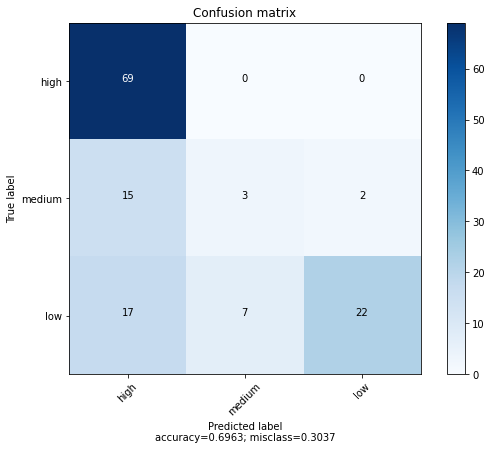

In [38]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
plot_confusion_matrix(confusion_matrix(y_test, clf_rf.predict(X_test)),['high','medium','low'],normalize=False)